In [1]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, normalization
from scipy.optimize import curve_fit
import math
import os
import time
import pymysql



from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from keras.layers import GRU

from sklearn.model_selection import KFold
os.environ['KERAS_BACKEND']='tensorflow'

# 输出序列长度
outseq = 240


Using TensorFlow backend.


In [2]:
def plot_origin(dataset):
    groups=[0,1,2,3,4,5,6,7,8]
    i=1
    plt.figure(figsize=(25, 20))
    for group in groups:
        plt.subplot(len(groups),1,i)
        plt.plot(dataset.values[:,group])
        plt.title(dataset.columns[group],y=0.5,loc='right')
        i+=1
    plt.show()

In [3]:
path1="E:\PythonProjects\BalloonTP\data\\train\\test.txt"
dataset = pd.read_table(path1, header=0, index_col=0)

print(dataset.head(5))

                     pressure  temperature  humidity  nSpeed  eSpeed  vSpeed  \
time                                                                           
2019-04-28 19:12:38   1005.64        14.34     97.07    0.00    0.01    0.10   
2019-04-28 19:12:39   1005.80        14.35     97.18   -0.01    0.00    0.13   
2019-04-28 19:12:40   1005.95        14.38     96.94   -0.09    0.04    0.12   
2019-04-28 19:12:41   1005.64        14.37     96.59   -0.05    0.10    0.09   
2019-04-28 19:12:42   1005.80        14.36     96.59    0.01    0.06    0.09   

                      longitude   latitude  aboveSeaLevel  
time                                                       
2019-04-28 19:12:38  116.967973  30.623078           68.8  
2019-04-28 19:12:39  116.967973  30.623078           69.1  
2019-04-28 19:12:40  116.967973  30.623078           69.3  
2019-04-28 19:12:41  116.967973  30.623078           69.4  
2019-04-28 19:12:42  116.967973  30.623078           69.7  


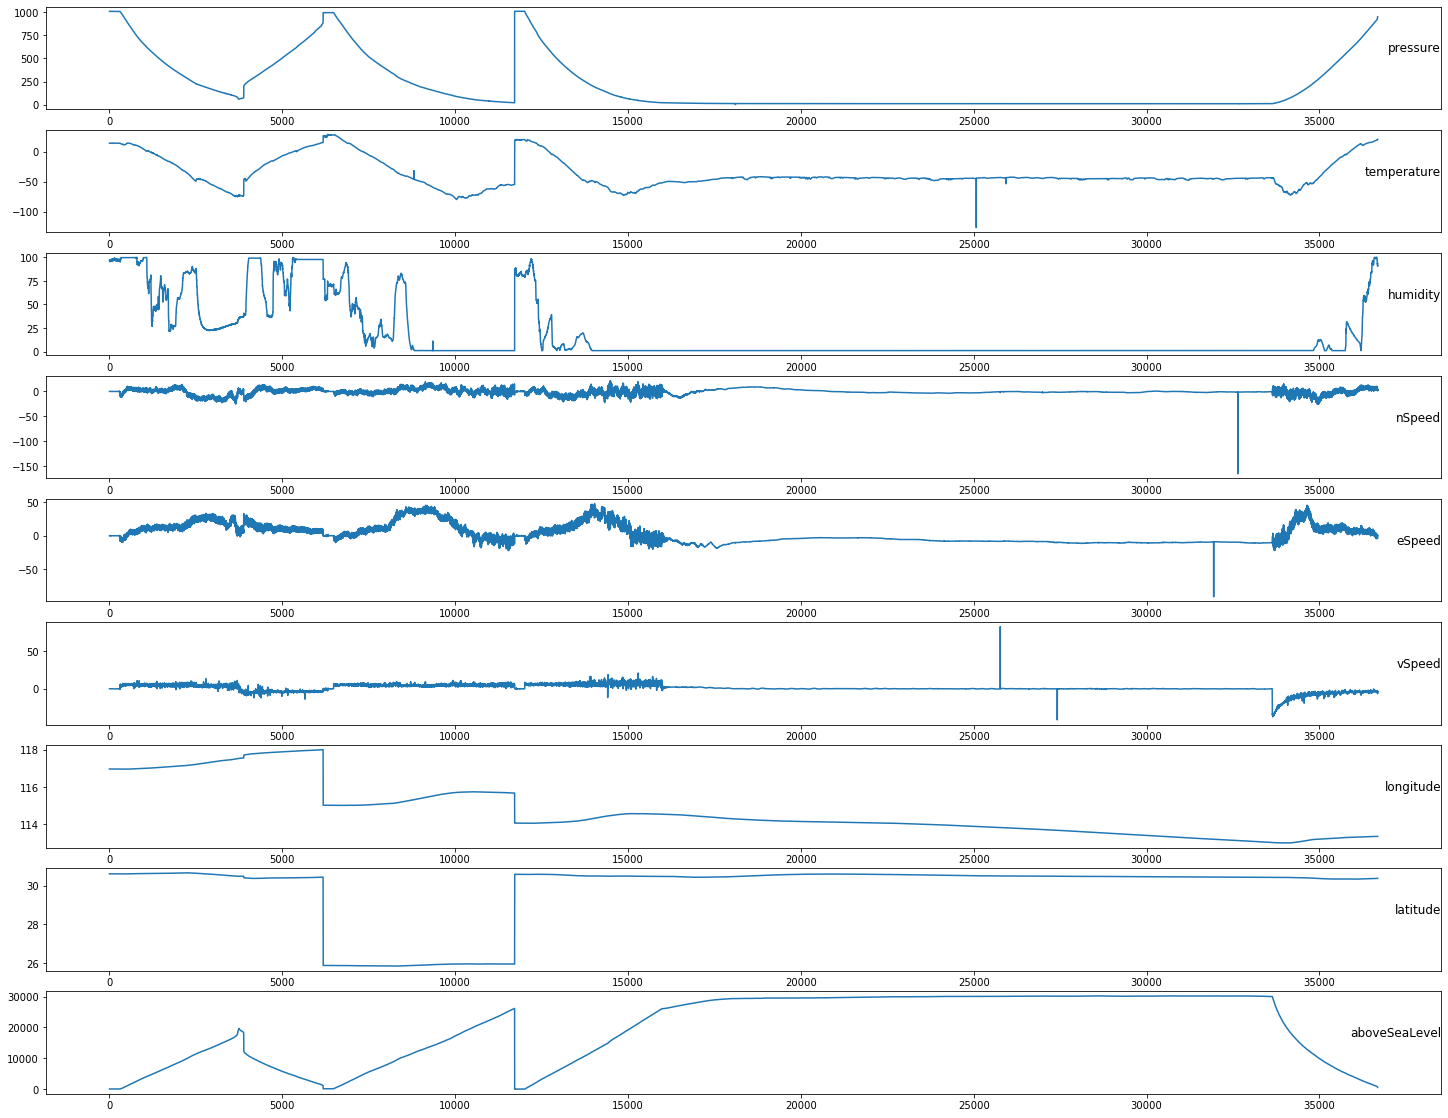

In [4]:
plot_origin(dataset)

In [5]:
def plot_result(history,x,y,scaler,range_number=-1):
    predicted_y=model_GRU.predict(x)
    # draw loss
    plt.figure(figsize=(20, 30))
    plt.subplot(411)
    plt.plot(history_GRU.epoch, history_GRU.history['loss'], )
    plt.plot(history_GRU.epoch, history_GRU.history['val_loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title(' Model Loss')
    plt.legend(['Training', 'Test'])
    #longitude
    plt.subplot(412)
    y[:,:-2]=rollback_normalize(y[:,:-2],scaler.data_min_[-3:-2],scaler.data_max_[-3:-2])
    predicted_y[:,:-2]=rollback_normalize(predicted_y[:,:-2],scaler.data_min_[-3:-2],scaler.data_max_[-3:-2])
    plt.plot(y[:range_number,:-2])
    plt.plot(predicted_y[:range_number,:-2])
    plt.xlabel('index')
    plt.ylabel('longitude')
    plt.title('longitude prediction')#'longitude','latitude','altitude'
    plt.legend(['Actual','Predicted'])
    #latitude
    plt.subplot(413)
    y[:,-2:-1]=rollback_normalize(y[:,-2:-1],scaler.data_min_[-2:-1],scaler.data_max_[-2:-1])
    predicted_y[:,-2:-1]=rollback_normalize(predicted_y[:,-2:-1],scaler.data_min_[-2:-1],scaler.data_max_[-2:-1])
    plt.plot(y[:range_number,1:-1])
    plt.plot(predicted_y[:range_number,1:-1])
    plt.xlabel('index')
    plt.ylabel('latitude')
    plt.title('latitude prediction')#'longitude','latitude','altitude'
    plt.legend(['Actual','Predicted'])
    #altitude
    plt.subplot(414)
    y[:,-1:]=rollback_normalize(y[:,-1:],scaler.data_min_[-1:],scaler.data_max_[-1:])
    predicted_y[:,-1:]=rollback_normalize(predicted_y[:,-1:],scaler.data_min_[-1:],scaler.data_max_[-1:])
    plt.plot(y[:range_number,2:])
    plt.plot(predicted_y[:range_number,2:])
    plt.xlabel('index')
    plt.ylabel('latitude')
    plt.title('latitude prediction')#'longitude','latitude','altitude'
    plt.legend(['Actual','Predicted'])
    plt.show()

In [6]:
def create_dataset(data,n_in=1,n_out=1,dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df=DataFrame(data)
    cols,names =list(),list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names =names+ [('var%d(t-%d)' %(j+1,i)) for j in range(n_vars)]
    
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names=names+[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names=names+[('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg=concat(cols,axis=1)
    agg.columns=names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
def rollback_normalize(alist,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(alist)):
            alist[i] = alist[i]*delta + low
    return alist

In [8]:
def get_normalized(data):
    data=data.astype('float32')
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(data)
    return scaled_data,scaler

In [9]:
# 二次曲线拟合
def func(x, a, b, c):
    return a * np.sqrt(x) * (b * np.square(x) + c)

def fitting(values):
    # 拟合速度列
    length = values.shape[0]
    x = [i for i in range(length)]
    x = np.array(x)
    for i in range(300, length, 300):
        y1 = np.array(values[i - 300:i, 3])
        y2 = np.array(values[i - 300:i, 4])
        y3 = np.array(values[i - 300:i, 5])
        # 非线性最小二乘法拟合
        popt1, pcov1 = curve_fit(func, x[i - 300:i], y1, maxfev=5000)
        popt2, pcov2 = curve_fit(func, x[i - 300:i], y2, maxfev=5000)
        popt3, pcov3 = curve_fit(func, x[i - 300:i], y3, maxfev=5000)
        # 获取popt里面是拟合系数
        # print(popt)
        a1 = popt1[0]
        b1 = popt1[1]
        c1 = popt1[2]
        a2 = popt2[0]
        b2 = popt2[1]
        c2 = popt2[2]
        a3 = popt3[0]
        b3 = popt3[1]
        c3 = popt3[2]
        yvals1 = func(x[i - 300:i], a1, b1, c1)  # 拟合y值
        yvals2 = func(x[i - 300:i], a2, b2, c2)  # 拟合y值
        yvals3 = func(x[i - 300:i], a3, b3, c3)  # 拟合y值

        values[i - 300:i, 3] = yvals1
        values[i - 300:i, 4] = yvals2
        values[i - 300:i, 5] = yvals3
    return values


# 抽样
def sampling(values):
    # 数据抽样，一分钟的数据取均值
    j = 0
    k = 0
    length = values.shape[0]
    new_values = []
    pressures = 0
    temperatures = 0
    humiditys = 0
    nSpeeds = 0
    eSpeeds = 0
    vSpeeds = 0
    longitudes = 0
    latitudes = 0
    aboveSeaLevels = 0
    for i in range(length):
        if j < 60:
            j = j + 1
            pressures = pressures + values[i, 0]
            temperatures = temperatures + values[i, 1]
            humiditys = humiditys + values[i, 2]
            nSpeeds = nSpeeds + values[i, 3]
            eSpeeds = eSpeeds + values[i, 4]
            vSpeeds = vSpeeds + values[i, 5]
            longitudes = longitudes + values[i, 6]
            latitudes = latitudes + values[i, 7]
            aboveSeaLevels = aboveSeaLevels + values[i, 8]
        else:
            j = 0
            new_values.append([])
            pressures = pressures / 60.0
            new_values[k].append(pressures)
            pressures = 0
            temperatures = temperatures / 60.0
            new_values[k].append(temperatures)
            temperatures = 0
            humiditys = humiditys / 60.0
            new_values[k].append(humiditys)
            humiditys = 0
            nSpeeds = nSpeeds / 60.0
            new_values[k].append(nSpeeds)
            nSpeeds = 0
            eSpeeds = eSpeeds / 60.0
            new_values[k].append(eSpeeds)
            eSpeeds = 0
            vSpeeds = vSpeeds / 60.0
            new_values[k].append(vSpeeds)
            vSpeeds = 0
            longitudes = longitudes / 60.0
            new_values[k].append(longitudes)
            longitudes = 0
            latitudes = latitudes / 60.0
            new_values[k].append(latitudes)
            latitudes = 0
            aboveSeaLevels = aboveSeaLevels / 60.0
            new_values[k].append(aboveSeaLevels)
            aboveSeaLevels = 0
            k = k + 1
    return new_values


# 训练数据处理
def train_data():
    # 文件路径
    rootdir = 'E:\PythonProjects\BalloonTP\data\\train2019'
    list = os.listdir(rootdir)  # 列出文件夹下所有的目录与文件
    print("数目%d" % len(list))
    data = []
    values = []
    new_values = []
    # 读取文件

    for i in range(2):
        path = os.path.join(rootdir, list[i])
        if os.path.isfile(path):
            data.append(pd.read_table(path, header=0, index_col=0))
            values.append(data[i].values)
            values[i] = fitting(values[i])
            new_values.append(sampling(values[i]))

    final_values = np.r_[new_values[0], new_values[1]]

    for i in range(2, len(list)):
        path = os.path.join(rootdir, list[i])
        if os.path.isfile(path):
            data.append(pd.read_table(path, header=0, index_col=0))
            values.append(data[i].values)
            values[i] = fitting(values[i])
            new_values.append(sampling(values[i]))
            final_values = np.r_[final_values, new_values[i]]
   

    return final_values

values=train_data()
#values=dataset.values()

数目271


D:\Users\13734\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Users\13734\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\minpack.py:788: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq


In [ ]:

scaled_data,scaler=get_normalized(values)
reframed=create_dataset(scaled_data,1 ,1)
kf = KFold(n_splits=5)
X,y=reframed.values[:,:9],reframed.values[:,-3:]
counter=0
historys=[]
test_ys=[]
test_Xs=[]
for trainset_index,testset_index in kf.split(reframed.values):
    train_X,train_y= X[trainset_index], y[trainset_index]
    test_X,test_y= X[testset_index], y[testset_index]
    train_X=train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    test_X=test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    model_GRU = Sequential()
    model_GRU.add(GRU(50, input_shape=(train_X.shape[1],train_X.shape[2])))
    model_GRU.add(Dense(3))
    model_GRU.compile(loss='mae',optimizer='adam',metrics=['mse','mae'])
    history_GRU=model_GRU.fit(train_X,train_y,epochs=50,batch_size=72,validation_data=(test_X,test_y),verbose=1,shuffle=False)
    historys.append(history_GRU)
    test_ys.append(test_y)
    test_Xs.append(test_X)
    counter=counter+1
    if(counter==1):
        break
    print("################################################################################")

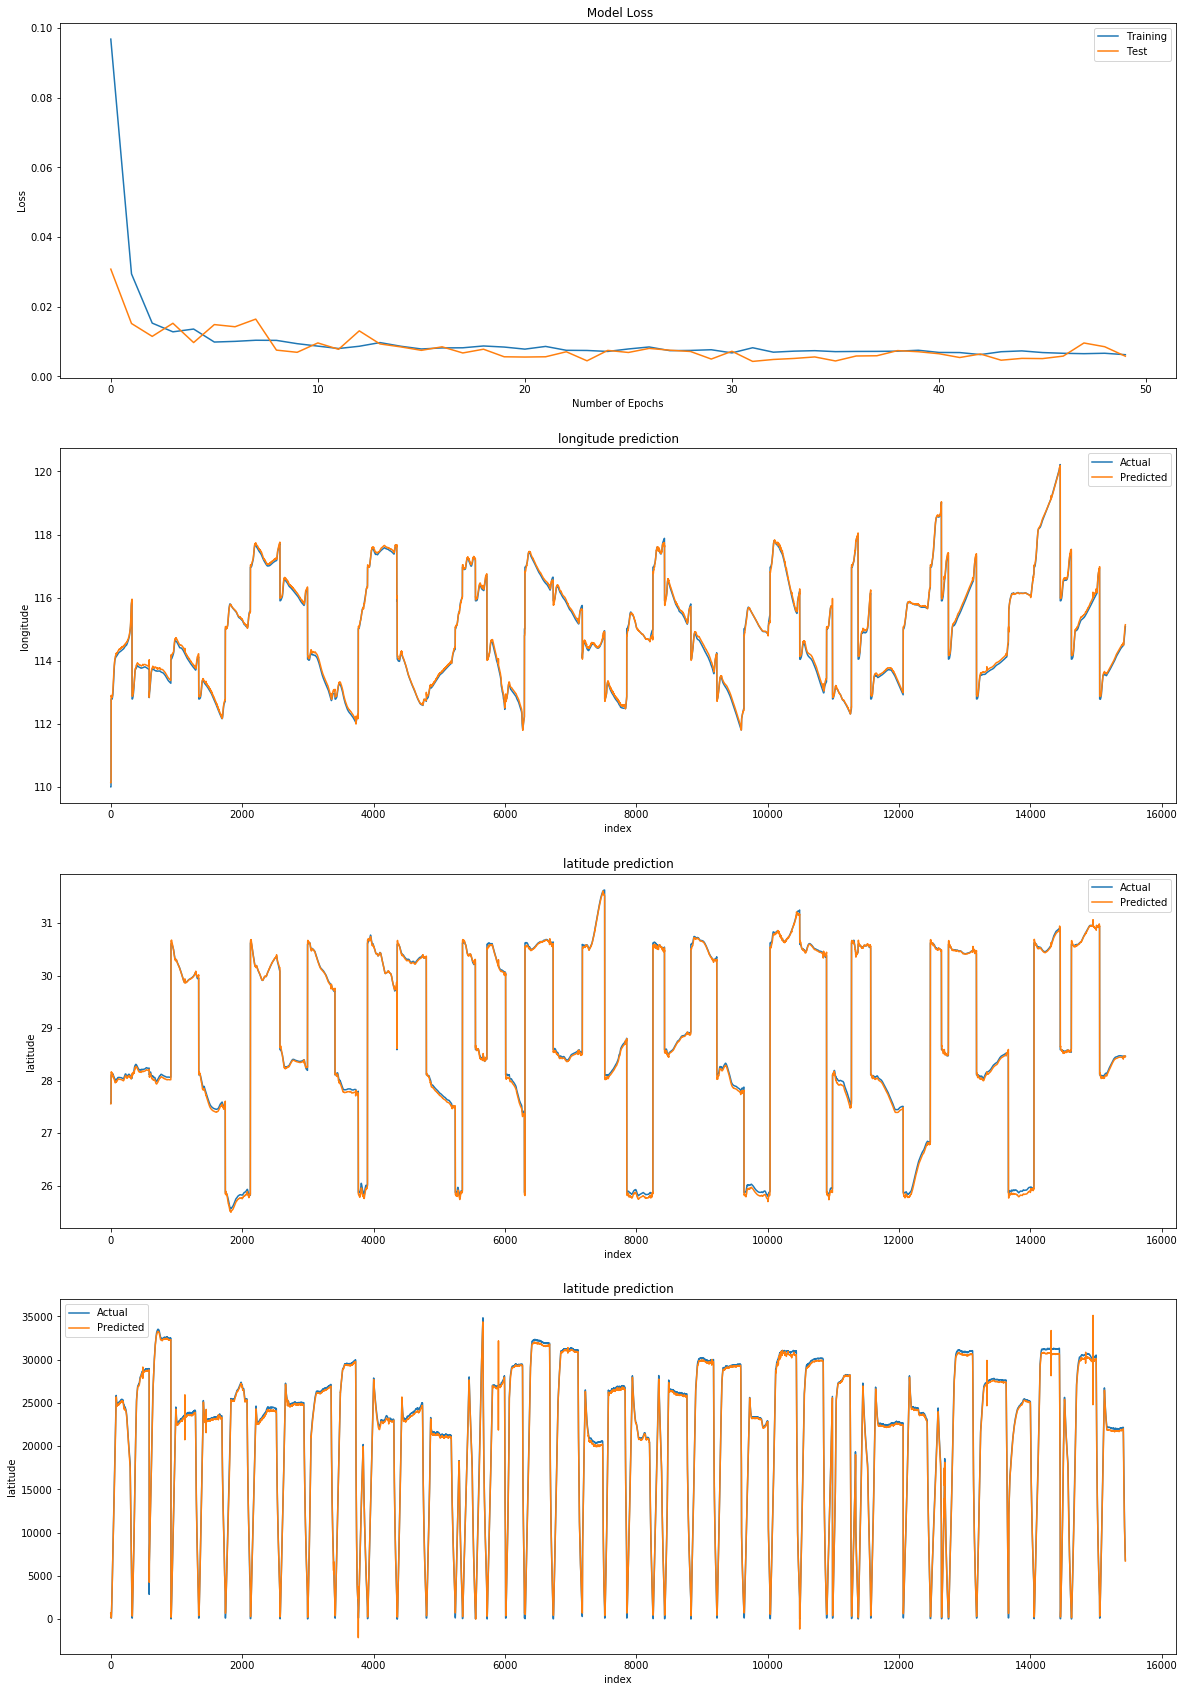

In [58]:
plot_result(historys[0],test_Xs[0],test_ys[0],scaler)
